In [25]:
import os, sys
import glob
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import tangram as tg
import torch

from pathlib import Path
from anndata import AnnData, read_h5ad

In [2]:
# Add Sanja's Tangram to the path
sys.path.append('/Users/adaly/Documents/Python/sTangram/')
from tangram_old import utils
from tangram_old import mapping_utils
from tangram_old import mapping_optimizer
from tangram_old import plot_utils

In [3]:
### Helper Functions ###

def downsample_to_smallest_category(
        adata,
        column="sample_short",
        random_state=None,
        min_cells=15,
        keep_small_categories=False
) -> sc.AnnData:
    """
    returns an annData object in which all categories in 'column' have
    the same size

    column
        column with the categories to downsample
    min_cells
        Minimum number of cells to downsample.
        Categories having less than `min_cells` are discarded unless
        keep_small_categories is True
    keep_small_categories
        Be default categories with less than min_cells are discarded.
        Set to true to keep them
    """
    counts = adata.obs[column].value_counts(sort=False)
    if len(counts[counts < min_cells]) > 0 and keep_small_categories is False:
        logging.warning(
            "The following categories have less than {} cells and will be "
            "ignored: {}".format(min_cells, dict(counts[counts < min_cells]))
        )
    min_size = min(counts[counts >= min_cells])
    sample_selection = None
    for sample, num_cells in counts.items():
        if num_cells <= min_cells:
            if keep_small_categories:
                sel = adata.obs.index.isin(
                    adata.obs[adata.obs[column] == sample].index)
            else:
                continue
        else:
            sel = adata.obs.index.isin(
                adata.obs[adata.obs[column] == sample]
                .sample(min_size, random_state=random_state)
                .index
            )
        if sample_selection is None:
            sample_selection = sel
        else:
            sample_selection |= sel
    logging.info(
        "The cells in category {!r} had been down-sampled to have each {} cells. "
        "The original counts where {}".format(column, min_size, dict(counts))
    )
    return adata[sample_selection].copy()

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

In [4]:
# Load a representative ST data file & parse gene names
st_datfile = '../data/ST_Test/CN51_C2_1_stdata_aligned_counts_IDs.txt.unified.tsv'
st_df = pd.read_csv(st_datfile, header=0, index_col=0, sep='\t')
st_genes = st_df.index.values

Load and preprocess single-cell data

In [5]:
sc_datfile = '../data/GSM3017261_20000_SC_nuclei.h5ad'
sc_all = sc.read_h5ad(sc_datfile)
sc.pp.normalize_total(sc_all)

# Only include genes present in ST data
sc_all = sc_all[:, sc_all.var_names.isin(st_genes)]

sc.pp.log1p(sc_all)  # log(x+1) transform count data
sc.pp.scale(sc_all)  # scale to unit variance and zero mean

# Downsample sc data for memory purposes -- discard BG cells; focus on predicting Neuron/Glia ratio
sc_down = downsample_to_smallest_category(sc_all, column='csplotch_annot',
                                         random_state=7, min_cells=5000, keep_small_categories=False)
shared_genes = sc_down.var_names
print(len(shared_genes), 'genes shared between SC and ST')

INFO:root:The cells in category 'csplotch_annot' had been down-sampled to have each 6790 cells. The original counts where {'BG': 780, 'Glia': 6790, 'Neuron': 14064}


9959 genes shared between SC and ST


In [22]:
# Calculate HVGs using raw snRNA count data
sc_raw = sc.read_h5ad(sc_datfile)
sc.pp.highly_variable_genes(sc_raw, flavor='seurat_v3', n_top_genes=500)

hvgs = list(sc_raw.var_names[sc_raw.var['highly_variable']])

Load and preprocess ST data

In [39]:
counts_dir = '../data/ST_Test/'
cellcomp_dir = '/Users/adaly/Dropbox (Simons Foundation)/cell_segmentation/AD_allspots_280/classes_tsvs/'

stdata_dict = {}

for cfile in glob.glob(os.path.join(counts_dir, '*.unified.tsv')):
    sample_name = Path(cfile).name.split('_stdata')[0]
    array_name = '_'.join(sample_name.split('_')[:2])
        
    afile = os.path.join(cellcomp_dir, array_name + '_celltype_annotations.csv')
    if os.path.exists(afile):
        annot_df = pd.read_csv(afile, header=0, index_col=0, sep=',')
        count_df = pd.read_csv(cfile, header=0, index_col=0, sep='\t')
        
        # Filter out spots missing annotation data
        shared = set(count_df.columns.values).intersection(set(annot_df['x_y']))
        count_df = count_df[shared]
                
        # Construct AnnData object with per-spot cell counts
        cell_counts, x_coords, y_coords = [], [], []
        for cstr in count_df.columns:
            row = annot_df[annot_df['x_y']==cstr]
            tot = row['MN_count'].values + row['Glia_count'].values + row['OtherN_count'].values
            cell_counts.append(tot[0])
            
            x, y = map(float, cstr.split('_'))
            x_coords.append(x)
            y_coords.append(y)
            
        obs = pd.DataFrame({'cell_count': cell_counts, 'x': x_coords, 'y': y_coords}, index=count_df.columns)
        var = pd.DataFrame(index=count_df.index)        
        stdata = AnnData(X=count_df.values.T, obs=obs, var=var)

        # Only keep genes shared between the two modalities
        stdata = stdata[:, stdata.var_names.isin(shared_genes)]
        
        # Normalize number of counts per spot
        sc.pp.normalize_total(stdata, target_sum=1e5)
        sc.pp.log1p(stdata)
        
        stdata_dict[sample_name] = stdata

Perform Tangram mapping

In [58]:
hyperparam = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
            'lambda_count' : 1, 'lambda_f_reg' : 1}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cell_mappings = {}

for key in stdata_dict.keys():
    print(key)
    st_sample = stdata_dict[key]
    print('Number of cells in spatial data:', sum(st_sample.obs.cell_count))
    print('Number of cells in scRNA data:', len(sc_down.obs.index))
    
    # Remove 0-count genes, ensure same genes present in same order
    adata_cells, adata_space = tg.pp_adatas(sc_down, st_sample, genes=hvgs)
    
    # Perform Tangram mapping
    ad_map = mapping_utils.map_cells_to_space(
        adata_cells = adata_cells,
        adata_space = adata_space,
        mode = 'cells',
        num_epochs = 1000,
        scale = False,
        d = np.array(st_sample.obs.cell_count) / st_sample.obs.cell_count.sum(),
        device = device,
        target_count = stdata.obs.cell_count.sum(),
        **hyperparam)
    ad_map.write_h5ad('tangram_map_%s.h5ad' % key)
    
    # Annotation transfer
    df_classes = tg.ut.one_hot_encoding(adata_cells.obs.csplotch_annot)
    df_vox_cells = pd.DataFrame({
        'x' : ad_map.var.x, 
        'y' : ad_map.var.y, 
        'cell_n' : ad_map.var.cell_count})
    resulting_voxels = np.argmax(ad_map.X, axis=1)  # spots to which cells are most likely assigned
    
    filtered_voxels_to_types = []  # Map of (spot_ind, cell_type)
    for i in range(len(resulting_voxels)):
        if ad_map.uns['F_out'][i] > 0.9:
            spot_ind = resulting_voxels[i]
            filtered_voxels_to_types.append((spot_ind, adata_cells.obs.csplotch_annot[i]))
    
    # Add columns tracking number of cells of each type in each spot
    for cind, ctype in enumerate(df_classes):
        df_vox_cells[ctype] = 0
    for spot_ind, cell_type in filtered_voxels_to_types:
        df_vox_cells.iloc[spot_ind, df_vox_cells.columns.get_loc(cell_type)] += 1
    
    cell_mappings[key] = df_vox_cells

CN51_C2_2
Number of cells in spatial data: 475
Number of cells in scRNA data: 13580


INFO:root:191 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 191 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.044, KL reg: 0.143
Score: 0.830, KL reg: 0.002
Score: 0.827, KL reg: 0.002
Score: 0.814, KL reg: 0.002
Score: 0.788, KL reg: 0.002
Score: 0.773, KL reg: 0.002
Score: 0.755, KL reg: 0.002
Score: 0.752, KL reg: 0.002
Score: 0.758, KL reg: 0.002
Score: 0.761, KL reg: 0.002


INFO:root:Saving results..


CN52_C2_1
Number of cells in spatial data: 1184
Number of cells in scRNA data: 13580


INFO:root:225 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 225 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.048, KL reg: 0.140
Score: 0.832, KL reg: 0.002
Score: 0.832, KL reg: 0.002
Score: 0.811, KL reg: 0.002
Score: 0.789, KL reg: 0.002
Score: 0.779, KL reg: 0.002
Score: 0.780, KL reg: 0.002
Score: 0.777, KL reg: 0.002
Score: 0.772, KL reg: 0.002
Score: 0.766, KL reg: 0.002


INFO:root:Saving results..


CN52_C2_2
Number of cells in spatial data: 1032
Number of cells in scRNA data: 13580


INFO:root:220 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 220 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.027, KL reg: 0.137
Score: 0.829, KL reg: 0.002
Score: 0.828, KL reg: 0.002
Score: 0.801, KL reg: 0.002
Score: 0.794, KL reg: 0.002
Score: 0.779, KL reg: 0.001
Score: 0.772, KL reg: 0.002
Score: 0.765, KL reg: 0.002
Score: 0.768, KL reg: 0.002
Score: 0.765, KL reg: 0.002


INFO:root:Saving results..


CN51_C2_1
Number of cells in spatial data: 434
Number of cells in scRNA data: 13580


INFO:root:213 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 213 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.055, KL reg: 0.107
Score: 0.826, KL reg: 0.002
Score: 0.832, KL reg: 0.001
Score: 0.797, KL reg: 0.001
Score: 0.773, KL reg: 0.001
Score: 0.770, KL reg: 0.001
Score: 0.758, KL reg: 0.001
Score: 0.741, KL reg: 0.001
Score: 0.738, KL reg: 0.002
Score: 0.739, KL reg: 0.001


INFO:root:Saving results..


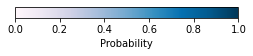

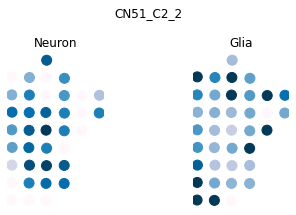

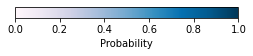

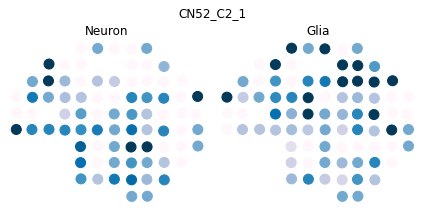

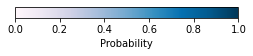

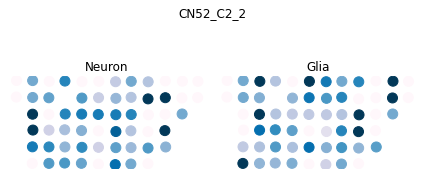

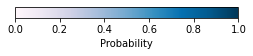

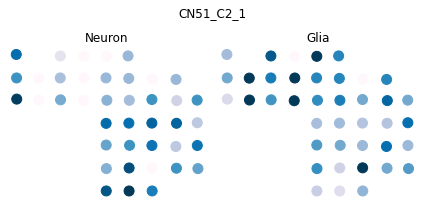

In [80]:
# Get percentages of each cell type in each spot after deconvolution
celltype_names = ['Neuron', 'Glia']

for array_name in cell_mappings.keys():
    tot_cells = np.sum([cell_mappings[array_name][ct] for ct in celltype_names], axis=0)
    tot_cells[tot_cells==0] = 1  # Deal with divide by zeros
    
    mapping_pct = pd.DataFrame({
        'x': cell_mappings[array_name]['x'],
        'y': cell_mappings[array_name]['y'],
    }, index=cell_mappings[array_name].index)
    for ct in celltype_names:
        mapping_pct[ct] = cell_mappings[array_name][ct] / tot_cells
    
    plot_utils.plot_decon_annotations(mapping_pct, nrows=1, ncols=2, robust=True, perc=0.05, s=100, cmap='PuBu')
    plt.suptitle(array_name)
    plt.tight_layout()
    plt.show()